In [19]:
# 01_intro_to_data.ipynb
# 📘 Introduction to the Starter Pack

# Requirements: pandas, numpy, matplotlib, seaborn (install via `pip install pandas numpy matplotlib seaborn`)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

DATA_DIR = Path("./data")

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = [14, 7]
sns.set_palette("crest")
pd.options.display.float_format = "{:.2f}".format

print("Data directory:", DATA_DIR.resolve())

Data directory: /home/bluescar/jupyter/cbb/starter_pack/artifacts/data


# 🧭 What You'll Explore

> **Beginner tip:** Run each cell in order using Shift+Enter. After a table prints, take a moment to read the column names—matching them with `00_data_dictionary.ipynb` will help the rest of the series feel familiar.

This notebook is your guided tour of the college basketball starter pack. You will:
- inspect the packaged seasons and choose one to analyze
- load the games, team, and player summary tables for that season
- slice schedules for a target team and compute quick context metrics
- preview season-long player leaderboards tied to that program
- build baseline visuals that you can extend in later notebooks


In [2]:
# 📅 Discover available seasons
season_files = sorted(p.stem for p in (DATA_DIR / "team_season_stats").glob('*.csv'))
print(f"Available seasons ({len(season_files)}):")
print(', '.join(season_files[:10]))
if len(season_files) > 10:
    print('…')
    print(', '.join(season_files[-5:]))

Available seasons (21):
2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014
…
2021, 2022, 2023, 2024, 2025


## 🛠️ Configure parameters
If you're unsure what to pick, leave the defaults in place for your first read-through. You can always change the values and run the cell again to watch how the preview updates.

Update the season, optional conference filter, and target team before re-running. The `TARGET_OPPONENT` parameter lets you narrow the schedule preview to a single matchup series.


In [9]:
# 🔁 Parameters
TARGET_SEASON = 2019  # choose one of the available seasons above
TARGET_CONFERENCE = None  # e.g. 'Big Ten' to focus on a single league
TARGET_TEAM = "Dayton"  # team to spotlight in schedule and player views
TARGET_OPPONENT = None  # e.g. 'Marquette' to isolate specific matchups
TOP_N_GAMES = 5  # number of games to show in the schedule preview table

print(f"Analyzing season: {TARGET_SEASON}")
print(f"Conference filter: {TARGET_CONFERENCE or 'All conferences'}")
print(f"Target team: {TARGET_TEAM}")
print(f"Target opponent: {TARGET_OPPONENT or 'All'}")
print(f"Games to display: {TOP_N_GAMES}")

Analyzing season: 2019
Conference filter: All conferences
Target team: Dayton
Target opponent: All
Games to display: 5


## 📥 Load core tables
This cell only reads files; it will not modify your data. Once it runs successfully, skim the `.head()` previews so you know the shape of each table before moving on.

Pull the finalized CSV assets for games, team season summaries, team game logs, and player season stats. Filtering is applied after loading so you can adjust the parameters and rerun quickly.


In [10]:
# 🗂️ Read season datasets
games_path = DATA_DIR / 'games.csv'
teams_path = DATA_DIR / 'teams.csv'
team_season_path = DATA_DIR / 'team_season_stats' / f'{TARGET_SEASON}.csv'
team_game_path = DATA_DIR / 'team_game_stats' / f'{TARGET_SEASON}.csv'
player_season_path = DATA_DIR / 'player_season_stats' / f'{TARGET_SEASON}.csv'

games = pd.read_csv(games_path)
teams = pd.read_csv(teams_path)
team_season = pd.read_csv(team_season_path)
team_game = pd.read_csv(team_game_path)
player_season = pd.read_csv(player_season_path)

games_target = games[games['season'] == TARGET_SEASON].copy()

# Filter out non-Division I teams
team_season = team_season.dropna(subset=['conference']).copy()
team_game = team_game.dropna(subset=['conference']).copy()
player_season = player_season.dropna(subset=['conference']).copy()

if TARGET_CONFERENCE:
    team_season = team_season[team_season['conference'] == TARGET_CONFERENCE].copy()
    team_game = team_game[team_game['conference'] == TARGET_CONFERENCE].copy()
    player_season = player_season[player_season['conference'] == TARGET_CONFERENCE].copy()

print(f"Games in season {TARGET_SEASON}: {len(games_target):,}")
print(f"Teams in scope: {len(team_season):,}")
print(f"Team game rows: {len(team_game):,}")
print(f"Player season rows: {len(player_season):,}")

display(team_season[['team', 'conference', 'games', 'wins', 'teamStats_rating']].head())

Games in season 2019: 6,250
Teams in scope: 359
Team game rows: 12,038
Player season rows: 4,876


/tmp/ipykernel_459297/2960221469.py:11: DtypeWarning: Columns (93) have mixed types. Specify dtype option on import or set low_memory=False.
  team_game = pd.read_csv(team_game_path)


,team,conference,games,wins,teamStats_rating
0,Abilene Christian,Southland,34,27,119.50
1,Air Force,Mountain West,32,14,104.00
2,Akron,MAC,33,17,128.80
3,Alabama A&M,SWAC,32,5,114.30
4,Alabama,SEC,34,18,103.40


## 🔍 Season overview
Focus on the counts for each `game_type` and the breakdown of conference games. These summaries confirm that your filters behaved the way you expect.

Summarize how the season is structured, including regular vs. tournament game volume and the span of the schedule.


In [13]:
# 📈 Season snapshot
games_target['start_date'] = pd.to_datetime(games_target['start_date'])

games_by_type = (
    games_target['game_type']
    .value_counts(dropna=False)
    .rename_axis('game_type')
    .reset_index(name='games')
    .sort_values('games', ascending=False)
)

conference_split = (
    games_target['conference_game']
    .value_counts(dropna=False)
    .rename_axis('conference_game')
    .reset_index(name='games')
)

season_range = games_target['start_date'].agg(['min', 'max'])
print(
    "Season span:",
    season_range['min'].date() if pd.notna(season_range['min']) else 'N/A',
    "to",
    season_range['max'].date() if pd.notna(season_range['max']) else 'N/A'
)

display(games_by_type)
display(conference_split)

Season span: 2018-11-06 to 2019-04-09


,game_type,games
0,STD,5412
1,TRNMNT,838


,conference_game,games
0,True,3516
1,False,2734


## 🧾 Team season snapshot
Look for familiar programs in the output and compare their win percentage and net rating columns. Seeing real team names helps connect the numbers to on-court performance.

Review top-line efficiency numbers for the strongest teams in scope.


In [14]:
# 🥇 Top teams by season rating
team_leaders = (
    team_season
    .sort_values('teamStats_rating', ascending=False)
    .head(10)
    [[
        'team', 'conference', 'games', 'wins', 'losses',
        'teamStats_rating', 'opponentStats_rating', 'teamStats_trueShooting'
    ]]
)
display(team_leaders)

,team,conference,games,wins,losses,teamStats_rating,opponentStats_rating,teamStats_trueShooting
124,Jackson State,SWAC,32,13,19,225.10,241.10,48.40
172,Mississippi Valley State,SWAC,32,6,26,201.00,245.90,46.60
133,Kennesaw State,ASUN,32,6,26,195.00,235.20,46.00
328,VCU,A-10,33,25,8,194.00,169.10,54.10
83,Florida A&M,MEAC,31,12,19,192.10,204.50,51.80
289,Texas A&M-Corpus Christi,Southland,32,14,18,186.50,186.30,52.10
101,Grambling,SWAC,34,17,17,184.20,177.80,56.90
257,San Francisco,WCC,31,21,10,184.10,163.60,56.10
291,Texas Southern,SWAC,38,24,14,182.00,177.70,55.10
194,North Alabama,ASUN,32,10,22,180.10,199.30,49.10


## 🧭 Explore the target team's schedule
Use the printed table to answer: Who did this team play, where, and what happened recently? Try adjusting `TARGET_OPPONENT` to narrow the schedule, then rerun the cell.

Slice the game log for the selected team, optionally restricting to a specific opponent, and calculate quick scoring context.


In [15]:
# 🗓️ Target team schedule
team_schedule = team_game[team_game['team'] == TARGET_TEAM].copy()
if team_schedule.empty:
    raise ValueError("No games found for TARGET_TEAM. Check spelling or adjust filters.")

if TARGET_OPPONENT:
    team_schedule = team_schedule[team_schedule['opponent'] == TARGET_OPPONENT].copy()
    if team_schedule.empty:
        raise ValueError("No games found against TARGET_OPPONENT. Clear the filter to continue.")

team_schedule['startDate'] = pd.to_datetime(team_schedule['startDate'])
team_schedule['margin'] = team_schedule['teamStats_points_total'] - team_schedule['opponentStats_points_total']

schedule_columns = [
    'startDate', 'opponent', 'isHome', 'neutralSite', 'conferenceGame',
    'teamStats_points_total', 'opponentStats_points_total', 'margin',
    'teamStats_rating', 'opponentStats_rating'
]

schedule_preview = (
    team_schedule
    .sort_values('startDate')
    [schedule_columns]
    .head(TOP_N_GAMES)
)

display(schedule_preview)

,startDate,opponent,isHome,neutralSite,conferenceGame,teamStats_points_total,opponentStats_points_total,margin,teamStats_rating,opponentStats_rating
305,2018-11-08 05:00:00+00:00,North Florida,True,False,False,78,70,8,113.00,102.90
669,2018-11-11 05:00:00+00:00,Coppin State,True,False,False,76,46,30,105.60,63.90
1276,2018-11-17 05:00:00+00:00,Purdue Fort Wayne,True,False,False,91,80,11,121.30,108.10
1940,2018-11-22 05:00:00+00:00,Butler,False,True,False,69,64,5,103.00,97.00
2003,2018-11-23 02:01:00+00:00,Virginia,True,True,False,59,66,-7,107.30,117.90


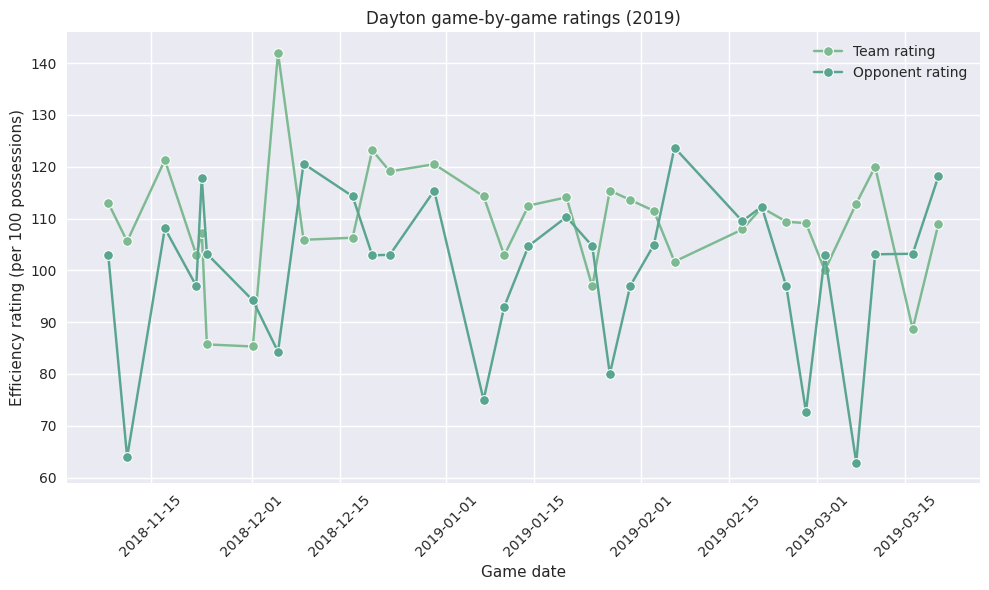

In [20]:
# 📈 Net rating trend across the season
trend = team_schedule.sort_values('startDate')

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=trend, x='startDate', y='teamStats_rating', marker='o', ax=ax, label='Team rating')
sns.lineplot(data=trend, x='startDate', y='opponentStats_rating', marker='o', ax=ax, label='Opponent rating')
ax.set_title(f'{TARGET_TEAM} game-by-game ratings ({TARGET_SEASON})')
ax.set_xlabel('Game date')
ax.set_ylabel('Efficiency rating (per 100 possessions)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 👤 Player season leaders
These leaderboards show who carried the scoring load or handled the ball. If you're new to efficiency metrics, start with `points`, `usage`, and `trueShootingPct` to spot standouts.

Surface the top contributors for the target team using the player season summary table. Adjust the sort order or metrics to focus on different skill sets.


In [21]:
# 🔝 Player leaderboard
player_scope = player_season[player_season['team'] == TARGET_TEAM].copy()
if player_scope.empty:
    print('No player rows for the target team; showing overall conference/season leaders instead.')
    player_scope = player_season.copy()

leader_table = (
    player_scope
    .sort_values(['points', 'trueShootingPct'], ascending=[False, False])
    .head(10)
    [[
        'name', 'position', 'team', 'conference', 'games', 'minutes', 'points',
        'trueShootingPct', 'usage', 'offensiveRating', 'defensiveRating', 'netRating'
    ]]
)
display(leader_table)

,name,position,team,conference,games,minutes,points,trueShootingPct,usage,offensiveRating,defensiveRating,netRating
872,Obi Toppin,F,Dayton,A-10,33,873,475,0.70,25.50,122.50,100.40,22.10
870,Jalen Crutcher,G,Dayton,A-10,33,1204,434,0.54,22.50,106.10,105.40,0.70
875,Josh Cunningham,F,Dayton,A-10,31,909,412,0.66,22.90,116.70,104.70,12.00
873,Ryan Mikesell,F,Dayton,A-10,33,989,334,0.63,17.40,120.00,102.30,17.70
866,Jordan Davis,G,Dayton,A-10,33,1064,323,0.53,18.20,102.10,105.00,-2.90
874,Trey Landers,G,Dayton,A-10,32,876,263,0.53,18.70,104.80,100.60,4.20
867,Dwayne Cohill,G,Dayton,A-10,33,509,114,0.51,15.00,92.80,106.50,-13.70
869,Jhery Matos,G,Dayton,A-10,6,117,22,0.38,15.10,85.50,97.40,-11.90
865,Frankie Policelli,F,Dayton,A-10,20,96,18,0.40,15.60,85.90,106.40,-20.50
877,Jack Westerfield,G,Dayton,A-10,9,25,8,0.47,20.50,91.50,95.20,-3.70


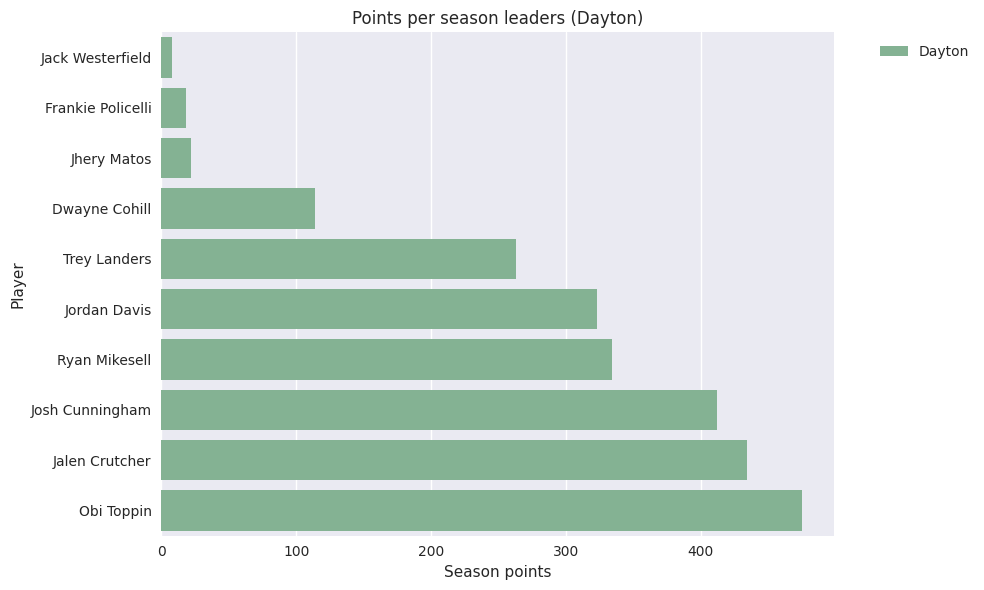

In [22]:
# 🎯 Points leaders bar chart
plot_players = leader_table.copy().sort_values('points', ascending=True)
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=plot_players, x='points', y='name', hue='team', dodge=False, ax=ax)
ax.set_title(f'Points per season leaders ({TARGET_TEAM if TARGET_TEAM in plot_players["team"].values else TARGET_SEASON})')
ax.set_xlabel('Season points')
ax.set_ylabel('Player')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## ✅ Next steps
Revisit these summaries after you experiment with other notebooks—they provide a consistent way to double-check that your filters still match the story you want to tell.

- Join `team_game_stats` to `games.csv` for richer context such as venue and neutral/campus splits.
- Explore `player_game_stats` for game-by-game scouting reports or momentum tracking.
- Feed the derived tables into downstream notebooks (rankings, similarity, matchup explorers) to build on this baseline tour.
